# A joint multilevel model for CAR 
Using multilevel.CARLeroux
## Common Markov Gaussian Random Field
 $$ [P , S ] = [P | GMRF] [ S | GMRF] $$

In [1]:
## Run the script
setwd('/apps/external_plugins/biospytial_rwrapper/biospytial.rwrapper/R/')
source("run-joint-multilevel-birds.R")


[1] "Load data source and preprocess"


Loading required package: MASS
Loading required package: Rcpp

Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [2]:

trials = rep(1,2 *nK)
burnin = 5000
n.sample = 10000
thin = 5

#burnin = 500
#n.sample = 1000
#thin = 1

l <- list()
i = 1
nS = dim(Py)[1]

nonas = which(! is.na(DataFrame$species) )
Y_withoutNA = DataFrame$species[nonas]
validate = createFolds(y = Y_withoutNA, k=7, returnTrain = FALSE)

validate.index.presences = lapply(validate, function(x){x + nS})

## customised for the multilevel preprocessing (i.e. DD instead of the trad. variable that I called `DataFrame` )
DD$presences <- DD$response
DD$predicted_values_CV <- NA


## Configure correlation for each cell.
## In this case, the correlation (similar to nugget effect) will be the same for all cells in P and for all cells in S.
## It can also be changed to assign correlations for same cell (i.e. the correlation between the cell i,j in S is the same as in P)
ind.re = c(rep(1,nK),rep(2,nK))




In [3]:
formula_sample =  sample ~ Disttoroadm + Populationm
formula_presence = species ~ Elevationm + Precipitationm
formula <- response ~ Disttoroadm + Populationm + Elevationm + Precipitationm

for (fold in validate.index.presences) {
    
    ## Substitue by NA (to be predicted..)
    DD$response[fold] <- NA
    
    model2 <- S.CARmultilevel(formula,family = 'binomial',
                             trials=trials,
                             W=M_bis,
                             ind.area=idarea,
                             #ind.re=factor(idarea),
                             ind.re = factor(ind.re),
                             rho=1,
                             burnin=burnin,
                             n.sample=n.sample,
                             data=DD)
    
    ## return DataFrame$species to original 
    ## Beware of DD...
    DD$response <- DD$presences
    ## Return original values
    ## Aquí hay que ver si los fitted values corresponden al indice 
    predicted.probability = model2$fitted.values[fold]
    DD$predicted_values_CV[fold] <- predicted.probability

    pROC_obj <- roc(DD$response[fold],predicted.probability)

    l[[i]] <- pROC_obj
    i = i + 1
}

Setting up the model.
Generating 5000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  147.8 seconds.


Setting levels: control = 0, case = 1
Setting direction: controls > cases


Setting up the model.
Generating 5000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  141.6 seconds.


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Generating 5000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  144.7 seconds.


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Generating 5000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  142.2 seconds.


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Generating 5000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  144 seconds.


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Generating 5000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  143.2 seconds.


Setting levels: control = 0, case = 1
Setting direction: controls < cases


Setting up the model.
Generating 5000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  144.3 seconds.


Setting levels: control = 0, case = 1
Setting direction: controls < cases


In [4]:
post.sample = data.frame(model2$fitted)
sample.S <- post.sample[1:nK,]
sample.P <- post.sample[(nK +1) : (2*nK) ,]

In [5]:
dim(post.sample)

[1] 8120    1

In [6]:
predicted_values <- DD$predicted_values_CV[(nK +1) : (2*nK)]

In [7]:
joint_SP <- sample.S * predicted_values

In [8]:
presences.index = seq(nK + 1 ,dim(DD)[1])

In [9]:
length(DD$response[presences.index])

[1] 4060

This is wrong we need to multiply the prob


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in plot.ci.se(sens.ci, type = "shape", col = "lightblue"):
“Low definition shape.”

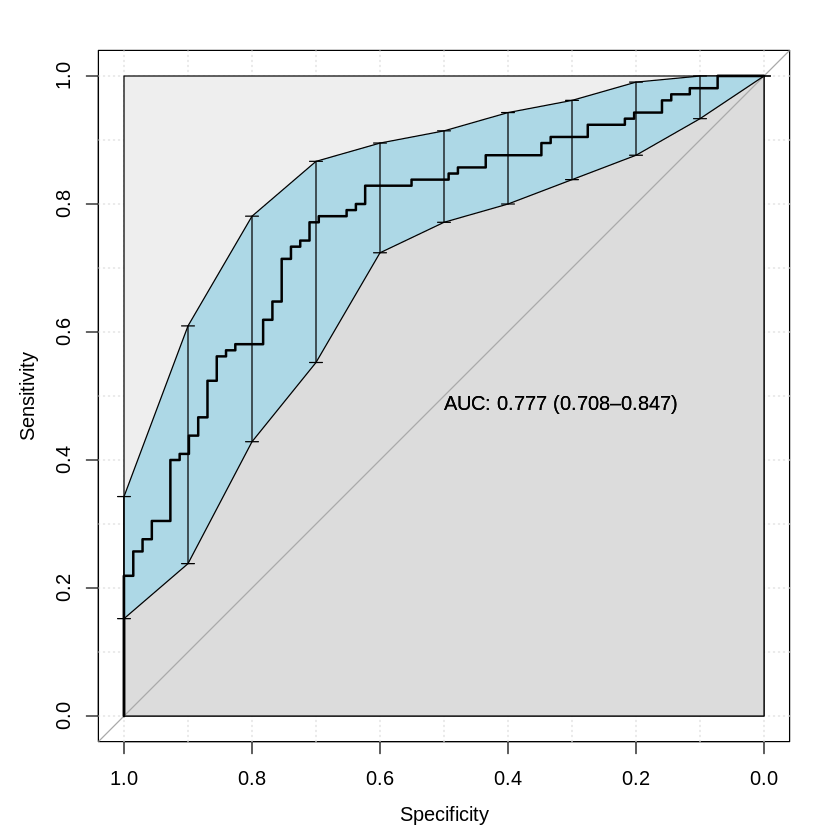

In [10]:
#pROC_obj <- roc(DD$response[presences.index],DD$predicted_values_CV[presences.index],
pROC_obj <- roc(DD$response[presences.index],joint_SP,                
               smoothed= TRUE,
               ci = TRUE, ci.alpha=0.9, stratified=FALSE,
               plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
               print.auc=TRUE, show.thres=TRUE)
sens.ci <- ci.se(pROC_obj)
plot(sens.ci,type="shape",col="lightblue")
plot(sens.ci, type="bars")



In [ ]:
#formula_sample =  sample ~ Disttoroadm + Populationm
#formula_presence = species ~ Elevationm + Precipitationm
formula <- response ~ Disttoroadm + Populationm + Elevationm + Precipitationm
ind.re = c(rep(1,nK),rep(2,nK))
burnin = 10000
n.sample = 20000
thin = 5
model2 <- S.CARmultilevel(formula,family = 'binomial',
                          trials=trials,
                          W=M_bis,
                          ind.area=idarea,
                          #ind.re=factor(idarea),
                          ind.re = factor(ind.re),
                          rho=1,
                          burnin=burnin,
                          n.sample=n.sample,
                          data=DD)

Setting up the model.
Generating 10000 post burnin and thinned (if requested) samples.
  |=====                                                                 |   7%

## Remember to check likelihood modelfit

In [ ]:
# witho NA's in Y
model2$modelfit

In [4]:
# with NA's in Y
model2$modelfit

DIC           p.d          WAIC           p.w          LMPL 
    4251.0844     1044.1655     4192.2224      792.2055    -2185.7292 
loglikelihood 
   -1081.3767

In [5]:
## With nas in Y and X
model2$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
(Intercept),-1.7586,-2.1658,-1.4598,5000,51.3,89.4,1.3
Disttoroadm,-0.0001,-0.0002,0.0001,5000,51.3,267.2,-1.2
Populationm,0.0000,-0.0001,0.0001,5000,51.3,191.5,-1.7
Elevationm,-0.0001,-0.0003,0.0001,5000,51.3,94.5,-0.6
Precipitationm,0.0000,-0.0001,0.0002,5000,51.3,92.8,1.3
tau2,11.1410,7.8798,14.4931,5000,100.0,12.6,-0.4
sigma2,0.0096,0.0023,0.1185,5000,100.0,2083.3,1.1
rho,1.0000,1.0000,1.0000,NA,NA,NA,NA


In [6]:
## Function for extracting mean and tails.
getUpperLowerCI <- function(fitted_sample,prefix="",MARGIN=1){
    fp = partial(quantile,probs=c(0.025,0.5,0.975))
    quants =apply(X = fitted_sample,FUN = fp,MARGIN)
    mfitt = apply(fitted_sample,mean,MARGIN = MARGIN)
    vfitt = apply(fitted_sample,var,MARGIN = MARGIN)
    new_data = cbind(t(quants),mfitt,vfitt)
    l = as.list(c("q025","median","q0975","mean","variance"))
    nnames = lapply(l,function (x){return(paste(prefix,x,sep = '_'))})
    colnames(new_data) = nnames
    return(new_data)
}

In [7]:
dim(model2$samples$phi)

[1] 5000 4060

In [8]:
## Uncomment this if independent random effect is defined per cell 
## i.e. dim(model2$samples$zeta) == dim(model2$samples$phi)
#sample.re <- t(model2$samples$phi + model2$samples$zeta)

In [9]:
## Uncomment this if independent random effect is defined per process
## i.e. dim(model2$samples$zeta)[1] == 2 (one for each process)
sample.re.S <- model2$samples$phi + model2$samples$zeta[,1]
sample.re.P <- model2$samples$phi + model2$samples$zeta[,2]
#dim(model2$samples$fitted) = has double the number of cells (i.e. one per process)
post.sample = data.frame(model2$samples$fitted)
sample.S <- post.sample[,1:nK]
sample.P <- post.sample[,(nK +1) : (2*nK) ]

In [10]:
dim(post.sample)

[1] 5000 8120

In [11]:
sample.PS <- sample.S * sample.P

In [12]:
length(sample.PS)

[1] 4060

In [13]:
### Bernoulli sampling
pss  <- post.sample %>% mutate_all(function(p) rbernoulli(1,p))
## divide samples for S and P according to the order given up
pred.S <- pss[,1:nK]
pred.P <- pss[,(nK +1) : (2*nK) ]
nsample <- nrow(pred.S)
ProbS <- colSums(pred.S) / nsample
ProbP <- colSums(pred.P) / nsample
ProbPS = ProbP * ProbS

###  Reduce to tails and means

In [14]:
P = getUpperLowerCI(sample.P,prefix = 'P',MARGIN = 2)
S = getUpperLowerCI(sample.S,prefix = 'S',MARGIN = 2)
PS = getUpperLowerCI(sample.PS,prefix = 'PS',MARGIN = 2)
re.S = getUpperLowerCI(sample.re.S,prefix = 'reS',MARGIN = 2)
re.P = getUpperLowerCI(sample.re.P,prefix = 'reP',MARGIN = 2)
phi = getUpperLowerCI(model2$samples$phi,prefix = 'phi',MARGIN = 2)

In [15]:
chain <- cbind(TDF$cellids,phi,re.S,re.P,PS,P,S,ProbP,ProbS,ProbPS)

In [16]:
## Save to posterity
file_ = '/outputs/presence_only_models/modelCAR2_tyrannidae.csv'
write.csv(chain,file_)

### Extract and export Random Effects in the shape of raw sample

In [188]:
model2$samples$zeta

Markov Chain Monte Carlo (MCMC) output:
Start = 1 
End = 1 
Thinning interval = 1 
[1] NA

In [155]:

sample.re <- t(model2$samples$phi + model2$samples$zeta)
re.chain <- cbind(TDF$cellids,sample.re)
file2 <- '/outputs/presence_only_models/modelCAR_model2_randomeffect_multilevel.csv'
write.csv(re.chain,file2)

ERROR: Error in model2$samples$phi + model2$samples$zeta: non-conformable arrays


In [166]:
sample.re <- t(model2$samples$phi)
re.chain <- cbind(TDF$cellids,sample.re)
file2 <- '/outputs/presence_only_models/modelCAR_model2_phi_multilevel.csv'
write.csv(re.chain,file2)

In [167]:
sample.re <- t(model2$samples$zeta)
re.chain <- cbind(TDF$cellids,sample.re)
file2 <- '/outputs/presence_only_models/modelCAR_model2_zeta_multilevel.csv'
write.csv(re.chain,file2)

Warning message in cbind(TDF$cellids, sample.re):
“number of rows of result is not a multiple of vector length (arg 1)”

In [168]:
## P and S
## divide samples for S and P according to the order given up
fitted = model2$fitted.values
S <- fitted[1:nK]
P <- fitted[(nK +1) : (2*nK) ]
chain = cbind(TDF$cellids,S,P)
file_ = '/outputs/presence_only_models/modelCAR_model2_PS_multilevel.csv'
write.csv(chain,file_)


## Diagnostics, Mr. Gelmans, et.al

## Sample the posterior 

In [165]:
chain = cbind(TDF$cellids,probpres,prob_pps,prob_pss)
file_ = '/outputs/presence_only_models/modelCAR_model2_fitted_multilevel.csv'
write.csv(chain,file_)

## Posterior análisis with a varying C $\tau^2, \sigma^2$ denominator

In [609]:
# Read the file
bfile = '/outputs/presence_only_models/joint-model2-benchmark-denominator.csv'
res <- read.csv(bfile)

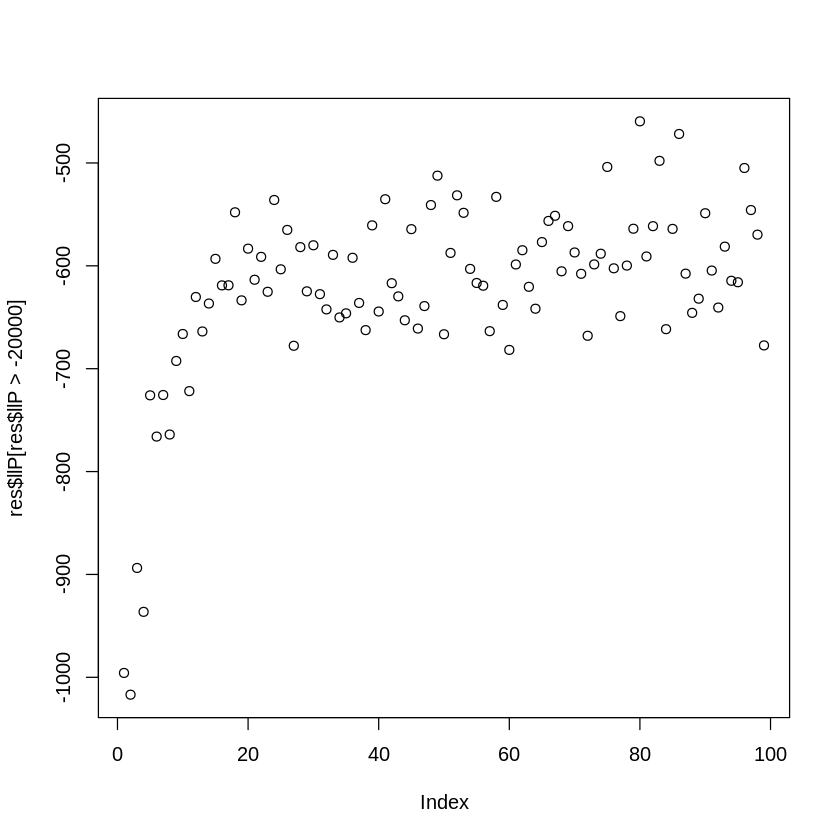